--- Starting AML Transaction Monitoring ML Model Implementation ---
Successfully loaded UK Sanctions List_mean.csv with 'latin1' encoding. Shape: (12376, 6)
FATAL: No suitable name column found in sanctions CSV. Using dummy data for sanctions.
An unexpected error occurred during sanctions data loading/cleaning: No name column found. Generating dummy sanctions data.
Generated fallback sanctions data due to error.
Successfully loaded customer data from customer_data.csv. Shape: (12820, 8)
Standardized customer column names: {'Customer_Id': 'Customer_ID', 'Customer_Name': 'Customer_Name', 'Customer_Address': 'Customer_Address', 'Customer_Dob': 'Customer_DOB', 'Customer_Nationality': 'Customer_Nationality', 'Customer_Country': 'Customer_Country', 'Customer_Industry': 'Customer_Industry', 'Onboarding_Date': 'Onboarding_Date'}
Customer DataFrame columns after standardization: ['Customer_ID', 'Customer_Name', 'Customer_Address', 'Customer_DOB', 'Customer_Nationality', 'Customer_Country', 'Cus

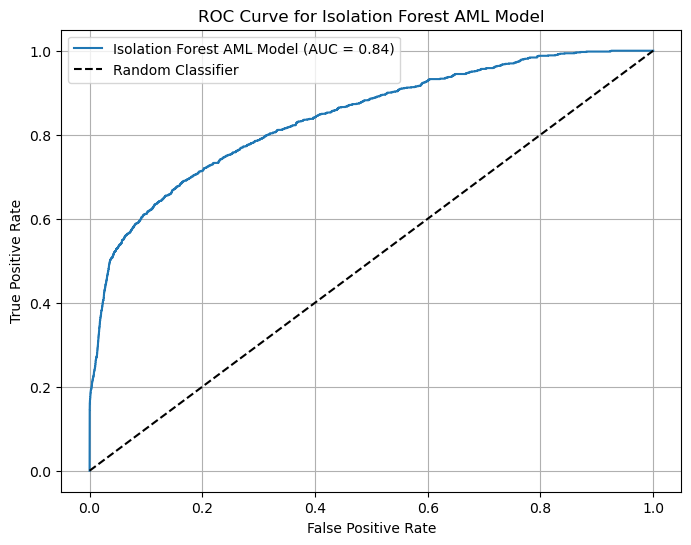

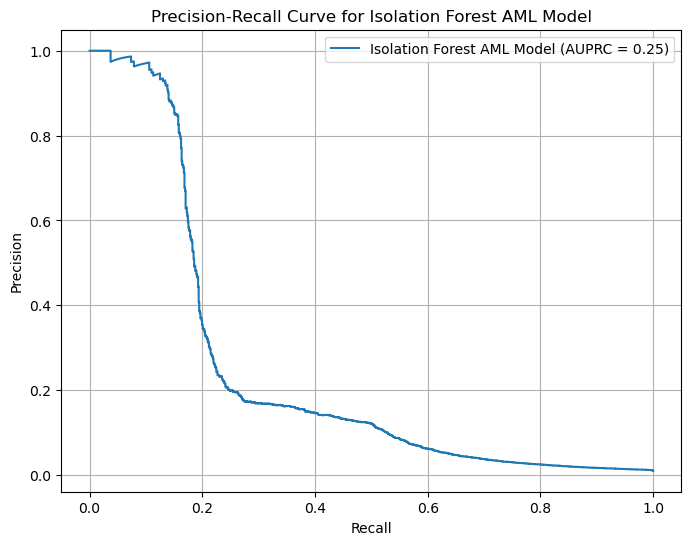

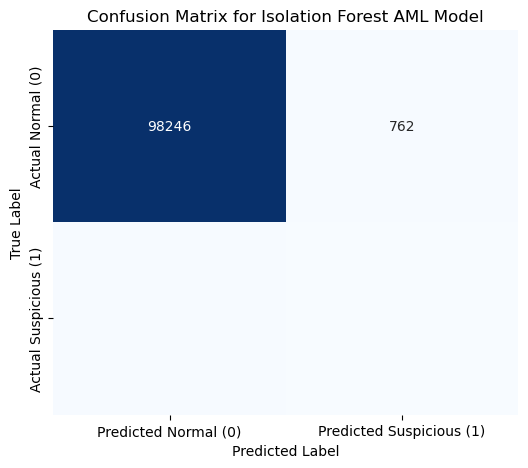


--- Performing AML Transaction Monitoring on 100000 transactions ---

--- Final AML Transaction Monitoring Results Summary ---
Total ALERTS: 992
Total OK: 99008

Top 10 AML Alerts (by anomaly score, lower is more anomalous):
      Transaction_ID Customer_ID  Amount_USD  Anomaly_Score AML_Alert_Flag
50129   TRANS0050129   CUST04934   906111.50      -0.098715          ALERT
30281   TRANS0030281   CUST09934   764374.90      -0.097363          ALERT
27192   TRANS0027192   CUST01634   982191.70      -0.093525          ALERT
7783    TRANS0007783   CUST09554   989458.35      -0.093469          ALERT
18027   TRANS0018027   CUST01560   964787.59      -0.092607          ALERT
17778   TRANS0017778   CUST02759   840657.24      -0.091253          ALERT
18463   TRANS0018463   CUST02712   948968.75      -0.090085          ALERT
28811   TRANS0028811   CUST06734   976986.02      -0.089738          ALERT
59474   TRANS0059474   CUST08075   993589.56      -0.087793          ALERT
79153   TRANS0079153   C

In [1]:
import pandas as pd
import numpy as np
import datetime
import random
import string
from sklearn.ensemble import IsolationForest # For anomaly detection
from sklearn.preprocessing import StandardScaler # For scaling features
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving/loading models

# --- Configuration and Global Variables (from previous step, ensuring consistency) ---
NUM_CUSTOMERS = 500 # Number of dummy customer records
NUM_TRANSACTIONS = 100000 # Number of dummy transaction records for this step

# Country Risk Map (simulated external data, consistent with previous step)
COUNTRY_RISK_MAP = {
    'IRAN': 'HIGH', 'NORTH KOREA': 'HIGH', 'SYRIA': 'HIGH', 'CUBA': 'HIGH', 'VENEZUULA': 'HIGH',
    'RUSSIA': 'MEDIUM', 'CHINA': 'MEDIUM', 'INDIA': 'LOW', 'USA': 'LOW', 'UK': 'LOW',
    'GERMANY': 'LOW', 'FRANCE': 'LOW', 'BRAZIL': 'MEDIUM', 'SOUTH AFRICA': 'MEDIUM',
    'NIGERIA': 'MEDIUM', 'AFGHANISTAN': 'HIGH', 'YEMEN': 'HIGH', 'SOMALIA': 'HIGH',
    'LEBANON': 'MEDIUM', 'PAKISTAN': 'MEDIUM'
}
HIGH_RISK_COUNTRIES = [country for country, risk in COUNTRY_RISK_MAP.items() if risk == 'HIGH']
LOW_RISK_COUNTRIES = [country for country, risk in COUNTRY_RISK_MAP.items() if risk == 'LOW']

# --- Helper Functions for Data Loading and Generation (from previous step, ensuring consistency) ---

def load_common_names_from_excel(filepath, sheet_name):
    """
    Loads a list of full names from an Excel file.
    Assumes the names are in a column named 'Sanctioned_name' in the specified sheet.
    Provides a fallback to a hardcoded list if the file or column is not found.
    """
    try:
        names_df = pd.read_excel(filepath, sheet_name=sheet_name)
        if 'Sanctioned_name' in names_df.columns:
            # print(f"Successfully loaded common names from '{filepath}' sheet '{sheet_name}'.")
            return names_df['Sanctioned_name'].astype(str).tolist()
        else:
            # print(f"Error: 'Sanctioned_name' column not found in '{sheet_name}' of '{filepath}'.")
            return _get_default_common_names()
    except FileNotFoundError:
        # print(f"Warning: Common names file '{filepath}' not found. Using default hardcoded names.")
        return _get_default_common_names()
    except Exception as e:
        # print(f"An error occurred while loading common names from Excel: {e}")
        return _get_default_common_names()

def _get_default_common_names():
    """Provides a hardcoded list of common names as a fallback."""
    return [
        'John Smith', 'Jane Johnson', 'Michael Williams', 'Emily Brown', 'David Jones',
        'Sarah Garcia', 'Chris Miller', 'Anna Davis', 'Robert Rodriguez', 'Maria Martinez',
        'William Taylor', 'Olivia Wilson', 'James Moore', 'Sophia White', 'Benjamin Green',
        'Isabella Hall', 'Lucas King', 'Mia Wright', 'Henry Lopez', 'Charlotte Hill'
    ]

def load_or_generate_initial_data(sanctions_csv_path='UK Sanctions List_mean.csv',
                                   customer_data_path='customer_data.csv',
                                   num_customers=None): # Changed default to None
    """
    Loads cleaned sanctions and customer data. If files are not found,
    it generates minimal dummy data for demonstration.
    """
    if num_customers is None: # Assign global if not provided
        num_customers = NUM_CUSTOMERS

    global COMMON_FULL_NAMES # Declare global to modify the list
    COMMON_FULL_NAMES = load_common_names_from_excel('Name_list.xlsx', 'Names') # Ensure this is loaded

    if not COMMON_FULL_NAMES:
        print("FATAL: COMMON_FULL_NAMES list is empty. Cannot proceed with data generation.")
        return pd.DataFrame(), pd.DataFrame() # Return empty DFs

    sanctions_df_cleaned = pd.DataFrame()
    customer_df = pd.DataFrame()

    try:
        # Load sanctions data with 'latin1' encoding for better compatibility
        raw_sanctions_df = pd.read_csv(sanctions_csv_path, encoding='latin1', header=1)
        print(f"Successfully loaded {sanctions_csv_path} with 'latin1' encoding. Shape: {raw_sanctions_df.shape}")

        # Clean and standardize sanctions data
        name_col = 'Name 6'
        address_col = 'Address 6'
        dob_col = 'DOB 6'
        nationality_col = 'Nationality 6'
        type_col = 'Type'
        id_col = 'ID'

        # Robust column handling for sanctions_df
        actual_name_col = name_col if name_col in raw_sanctions_df.columns else ('Name' if 'Name' in raw_sanctions_df.columns else None)
        actual_address_col = address_col if address_col in raw_sanctions_df.columns else ('Address' if 'Address' in raw_sanctions_df.columns else None)
        actual_dob_col = dob_col if dob_col in raw_sanctions_df.columns else ('DOB' if 'DOB' in raw_sanctions_df.columns else None)
        actual_nationality_col = nationality_col if nationality_col in raw_sanctions_df.columns else ('Nationality' if 'Nationality' in raw_sanctions_df.columns else None)
        actual_type_col = type_col if type_col in raw_sanctions_df.columns else ('Type' if 'Type' in raw_sanctions_df.columns else None)
        actual_id_col = id_col if id_col in raw_sanctions_df.columns else ('ID' if 'ID' in raw_sanctions_df.columns else None)

        if not actual_name_col:
            print(f"FATAL: No suitable name column found in sanctions CSV. Using dummy data for sanctions.")
            raise ValueError("No name column found") # Force fallback to dummy data

        sanctions_df_cleaned = raw_sanctions_df.copy()
        sanctions_df_cleaned['Sanctioned_Name'] = sanctions_df_cleaned[actual_name_col].astype(str).str.upper().str.strip()
        
        sanctions_df_cleaned['Sanctioned_Address'] = sanctions_df_cleaned[actual_address_col].astype(str).str.upper().str.strip() if actual_address_col and actual_address_col in sanctions_df_cleaned.columns else np.nan
        sanctions_df_cleaned['Sanctioned_DOB'] = pd.to_datetime(sanctions_df_cleaned[actual_dob_col], errors='coerce').dt.strftime('%Y-%m-%d') if actual_dob_col and actual_dob_col in sanctions_df_cleaned.columns else np.nan
        sanctions_df_cleaned['Sanctioned_Nationality'] = sanctions_df_cleaned[actual_nationality_col].astype(str).str.upper().str.strip() if actual_nationality_col and actual_nationality_col in sanctions_df_cleaned.columns else np.nan
        sanctions_df_cleaned['Sanction_Type'] = sanctions_df_cleaned[actual_type_col].astype(str).str.upper().str.strip() if actual_type_col and actual_type_col in sanctions_df_cleaned.columns else np.nan
        sanctions_df_cleaned['Sanctioned_ID'] = sanctions_df_cleaned[actual_id_col].astype(str) if actual_id_col and actual_id_col in sanctions_df_cleaned.columns else [f'S{i:04d}' for i in range(len(sanctions_df_cleaned))]

        sanctions_df_cleaned = sanctions_df_cleaned[[
            'Sanctioned_ID', 'Sanctioned_Name', 'Sanctioned_Address',
            'Sanctioned_DOB', 'Sanctioned_Nationality', 'Sanction_Type'
        ]].copy()
        sanctions_df_cleaned = sanctions_df_cleaned[
            (sanctions_df_cleaned['Sanctioned_Name'] != 'UNKNOWN SANCTIONED NAME') &
            (sanctions_df_cleaned['Sanctioned_Name'] != 'NAN') &
            (sanctions_df_cleaned['Sanctioned_Name'].str.strip() != '')
        ].reset_index(drop=True)
        print("Cleaned Sanctions Data (first 3 rows):")
        print(sanctions_df_cleaned.head(3))
        sanctions_df_cleaned.to_csv('sanctions_list_cleaned.csv', index=False) # Save cleaned version

    except FileNotFoundError:
        print(f"Error: Sanctions file '{sanctions_csv_path}' not found. Generating minimal dummy sanctions data.")
        # Fallback to dummy data
        sanctions_df_cleaned = pd.DataFrame({
            'Sanctioned_ID': [f'S{i:04d}' for i in range(1, 101)], # More dummy data
            'Sanctioned_Name': [f'SANCTIONED PERSON {i}' for i in range(1, 101)],
            'Sanctioned_Address': [f'{i*10} MAIN ST, HIGH RISK COUNTRY' for i in range(1, 101)],
            'Sanctioned_DOB': [f'{1950 + i}-01-01' for i in range(100)],
            'Sanctioned_Nationality': random.choices(HIGH_RISK_COUNTRIES, k=100),
            'Sanction_Type': random.choices(['INDIVIDUAL', 'ENTITY'], k=100)
        })
        print("Generated fallback sanctions data.")
    except Exception as e:
        print(f"An unexpected error occurred during sanctions data loading/cleaning: {e}. Generating dummy sanctions data.")
        # Fallback to dummy data even on other errors
        sanctions_df_cleaned = pd.DataFrame({
            'Sanctioned_ID': [f'S{i:04d}' for i in range(1, 101)], # More dummy data
            'Sanctioned_Name': [f'SANCTIONED PERSON {i}' for i in range(1, 101)],
            'Sanctioned_Address': [f'{i*10} MAIN ST, HIGH RISK COUNTRY' for i in range(1, 101)],
            'Sanctioned_DOB': [f'{1950 + i}-01-01' for i in range(100)],
            'Sanctioned_Nationality': random.choices(HIGH_RISK_COUNTRIES, k=100),
            'Sanction_Type': random.choices(['INDIVIDUAL', 'ENTITY'], k=100)
        })
        print("Generated fallback sanctions data due to error.")


    try:
        customer_df = pd.read_csv(customer_data_path)
        print(f"Successfully loaded customer data from {customer_data_path}. Shape: {customer_df.shape}")

        # --- IMPORTANT: Standardize customer column names to expected casing ---
        # Create a mapping from lowercase current column names to desired proper case
        # This makes the renaming robust to initial casing in the CSV
        current_cols_lower = {col.lower(): col for col in customer_df.columns}
        
        expected_customer_cols_mapping = {
            'customer_id': 'Customer_ID',
            'customer_name': 'Customer_Name',
            'customer_address': 'Customer_Address',
            'customer_dob': 'Customer_DOB',
            'customer_nationality': 'Customer_Nationality',
            'customer_country': 'Customer_Country',
            'customer_industry': 'Customer_Industry',
            'onboarding_date': 'Onboarding_Date'
        }
        
        rename_dict = {}
        for old_col_lower, new_col_proper in expected_customer_cols_mapping.items():
            if old_col_lower in current_cols_lower: # Check if the lowercase version of the column exists
                # Map the actual current column name to the desired proper case
                rename_dict[current_cols_lower[old_col_lower]] = new_col_proper
            elif new_col_proper not in customer_df.columns:
                # If neither original casing nor lowercase version exists, add it as NaN to prevent KeyError later.
                print(f"Warning: Customer column '{new_col_proper}' not found in loaded data. Creating as NaN.")
                customer_df[new_col_proper] = np.nan

        if rename_dict:
            customer_df.rename(columns=rename_dict, inplace=True)
            print(f"Standardized customer column names: {rename_dict}")
            
        print(f"Customer DataFrame columns after standardization: {customer_df.columns.tolist()}")

        # Final check for required columns after standardization
        required_customer_cols = ['Customer_ID', 'Customer_Name', 'Customer_Address', 'Customer_DOB', 'Customer_Nationality', 'Customer_Country']
        if not all(col in customer_df.columns for col in required_customer_cols):
            missing_cols = [col for col in required_customer_cols if col not in customer_df.columns]
            print(f"FATAL: Missing required customer columns after loading/standardization: {missing_cols}. Cannot proceed.")
            # If critical columns are missing, return empty customer_df
            customer_df = pd.DataFrame() 

    except FileNotFoundError:
        print(f"Customer data file '{customer_data_path}' not found. Generating dummy customer data.")
        customers = []
        for i in range(1, num_customers + 1):
            customer_id = f'CUST{i:05d}'
            customer_name = random.choice(COMMON_FULL_NAMES)
            customer_address = f"{random.randint(100, 999)} {random.choice(['Main St', 'Oak Ave', 'Pine Ln'])}"
            customer_dob = (datetime.date(1950, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 50))).strftime('%Y-%m-%d')
            customer_nationality = random.choice(list(COUNTRY_RISK_MAP.keys()))
            customer_country = random.choice(list(COUNTRY_RISK_MAP.keys()))
            customer_industry = random.choice(['Financial Services', 'Retail', 'Technology', 'Manufacturing', 'Healthcare'])
            onboarding_date = (datetime.date(2020, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 3))).strftime('%Y-%m-%d')

            # Introduce some 'risky' customers that might match sanctions list
            if i % 10 == 0 and not sanctions_df_cleaned.empty:
                sanctioned_entity = sanctions_df_cleaned.sample(1).iloc[0]
                customer_name = sanctioned_entity['Sanctioned_Name'].replace('A', 'a', 1).replace('E', 'e', 1) # Slight variation
                customer_address = sanctioned_entity['Sanctioned_Address'].replace('ST', 'Street', 1) # Slight variation
                customer_dob = sanctioned_entity['Sanctioned_DOB'] # Exact DOB match
                customer_nationality = sanctioned_entity['Sanctioned_Nationality']
                customer_country = sanctioned_entity['Sanctioned_Nationality']

            customers.append({
                'Customer_ID': customer_id,
                'Customer_Name': customer_name,
                'Customer_Address': customer_address,
                'Customer_DOB': customer_dob,
                'Customer_Nationality': customer_nationality,
                'Customer_Country': customer_country,
                'Customer_Industry': customer_industry,
                'Onboarding_Date': onboarding_date
            })
        customer_df = pd.DataFrame(customers)
        customer_df.to_csv(customer_data_path, index=False) # Save generated customer data
        print("Generated dummy customer data.")
    except Exception as e:
        print(f"An unexpected error occurred during customer data loading/generation: {e}. Generating dummy customer data.")
        # Ensure it's not empty, even on error
        customers = []
        for i in range(1, num_customers + 1):
            customer_id = f'CUST{i:05d}'
            customer_name = random.choice(COMMON_FULL_NAMES)
            customer_address = f"{random.randint(100, 999)} {random.choice(['Main St', 'Oak Ave', 'Pine Ln'])}"
            customer_dob = (datetime.date(1950, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 50))).strftime('%Y-%m-%d')
            customer_nationality = random.choice(list(COUNTRY_RISK_MAP.keys()))
            customer_country = random.choice(list(COUNTRY_RISK_MAP.keys()))
            customer_industry = random.choice(['Financial Services', 'Retail', 'Technology', 'Manufacturing', 'Healthcare'])
            onboarding_date = (datetime.date(2020, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 3))).strftime('%Y-%m-%d')
            customers.append({
                'Customer_ID': customer_id, 'Customer_Name': customer_name, 'Customer_Address': customer_address,
                'Customer_DOB': customer_dob, 'Customer_Nationality': customer_nationality, 'Customer_Country': customer_country,
                'Customer_Industry': customer_industry, 'Onboarding_Date': onboarding_date
            })
        customer_df = pd.DataFrame(customers)
        print("Generated fallback customer data due to error.")

    return sanctions_df_cleaned, customer_df


# --- Feature Engineering Function ---
def calculate_sanctions_features(df):
    """
    Calculates various matching and risk features for each customer-sanctioned entity pair.
    Uses more robust string matching.
    """
    # Define all expected columns that should be present in the input df
    # These are the columns expected from the training_samples or screening_pairs
    expected_input_cols = [
        'Customer_ID', 'Customer_Name', 'Customer_Address', 'Customer_DOB', 'Customer_Nationality', 'Customer_Country',
        'Sanctioned_ID', 'Sanctioned_Name', 'Sanctioned_Address', 'Sanctioned_DOB', 'Sanctioned_Nationality', 'Sanction_Type'
    ]
    # 'is_sanction_match' is added by generate_and_label_training_data, not expected as input to this function itself.

    if df.empty:
        # print("Warning: Input DataFrame for calculate_sanctions_features is empty. Returning empty DataFrame with expected columns.")
        # Define all expected feature columns to ensure consistent output structure
        # This list should include all original columns that need to be passed through
        # PLUS all newly generated feature columns.
        all_expected_output_cols = expected_input_cols + [
            'Customer_Name_Clean', 'Sanctioned_Name_Clean', 'Customer_Address_Clean', 'Sanctioned_Address_Clean',
            'Customer_Nationality_Clean', 'Sanctioned_Nationality_Clean', 'Customer_Country_Clean',
            'name_fuzz_ratio', 'name_token_sort_ratio', 'name_token_set_ratio', 'name_match_score',
            'address_match_score', 'dob_match', 'nationality_match', 'customer_country_risk_score',
            'sanction_type_severity_score', 'name_country_interaction', 'name_dob_interaction'
        ]
        # Add 'is_sanction_match' here if it's expected in the final output of generate_and_label_training_data
        # but not necessarily as an input to calculate_sanctions_features itself.
        if 'is_sanction_match' in df.columns: # Check if it was passed in
            all_expected_output_cols.append('is_sanction_match')
        return pd.DataFrame(columns=all_expected_output_cols)

    # Ensure all expected input columns are present, add as NaN if missing
    for col in expected_input_cols:
        if col not in df.columns:
            df[col] = np.nan # Add missing columns to prevent KeyError

    # Ensure columns are string type and clean them
    df['Customer_Name_Clean'] = df['Customer_Name'].astype(str).str.upper().str.strip()
    df['Sanctioned_Name_Clean'] = df['Sanctioned_Name'].astype(str).str.upper().str.strip()
    df['Customer_Address_Clean'] = df['Customer_Address'].astype(str).str.upper().str.strip()
    df['Sanctioned_Address_Clean'] = df['Sanctioned_Address'].astype(str).str.upper().str.strip()
    df['Customer_Nationality_Clean'] = df['Customer_Nationality'].astype(str).str.upper().str.strip()
    df['Sanctioned_Nationality_Clean'] = df['Sanctioned_Nationality'].astype(str).str.upper().str.strip()
    df['Customer_Country_Clean'] = df['Customer_Country'].astype(str).str.upper().str.strip()

    # Name Fuzzy Match Scores
    # fuzz.ratio: Simple Levenshtein ratio
    df['name_fuzz_ratio'] = df.apply(
        lambda row: fuzz.ratio(row['Customer_Name_Clean'], row['Sanctioned_Name_Clean']), axis=1
    )
    # fuzz.token_sort_ratio: Sorts tokens before matching, good for reordered names
    df['name_token_sort_ratio'] = df.apply(
        lambda row: fuzz.token_sort_ratio(row['Customer_Name_Clean'], row['Sanctioned_Name_Clean']), axis=1
    )
    # fuzz.token_set_ratio: Considers common tokens, robust to extra words
    df['name_token_set_ratio'] = df.apply(
        lambda row: fuzz.token_set_ratio(row['Customer_Name_Clean'], row['Sanctioned_Name_Clean']), axis=1
    )
    # Take the max of these for a comprehensive name score
    df['name_match_score'] = df[['name_fuzz_ratio', 'name_token_sort_ratio', 'name_token_set_ratio']].max(axis=1)


    # Address Fuzzy Match Score (using token_set_ratio for robustness to word order)
    df['address_match_score'] = df.apply(
        lambda row: fuzz.token_set_ratio(row['Customer_Address_Clean'], row['Sanctioned_Address_Clean']), axis=1
    )

    # Date of Birth Match (Exact match)
    df['dob_match'] = df.apply(
        lambda row: 1 if (pd.notna(row['Customer_DOB']) and pd.notna(row['Sanctioned_DOB']) and
                         str(row['Customer_DOB']) == str(row['Sanctioned_DOB'])) else 0, axis=1
    )
    
    # Nationality Match (Exact match)
    df['nationality_match'] = df.apply(
        lambda row: 1 if (pd.notna(row['Customer_Nationality_Clean']) and pd.notna(row['Sanctioned_Nationality_Clean']) and
                         row['Customer_Nationality_Clean'] == row['Sanctioned_Nationality_Clean']) else 0, axis=1
    )

    # Country Risk Factor for Customer's Country
    df['customer_country_risk_score'] = df['Customer_Country_Clean'].map(
        {k: (10 if v == 'HIGH' else 5 if v == 'MEDIUM' else 1) for k, v in COUNTRY_RISK_MAP.items()}
    ).fillna(0) # Assign 0 if country not in map

    # Sanction Type Encoding (Numerical severity)
    sanction_type_severity = {
        'INDIVIDUAL': 10,
        'ENTITY': 8,
        'VESSEL': 5,
        'AIRCRAFT': 5,
        'NAN': 0,
        'UNKNOWN': 0 # Handle any other missing/unknown types
    }
    df['sanction_type_severity_score'] = df['Sanction_Type'].map(sanction_type_severity).fillna(0)

    # Interaction features (example)
    df['name_country_interaction'] = df['name_match_score'] * df['customer_country_risk_score']
    df['name_dob_interaction'] = df['name_match_score'] * df['dob_match']

    return df

# --- Training Data Generation and Labeling ---
def generate_and_label_training_data(customer_df, sanctions_df_cleaned, num_samples=20000):
    """
    Generates a simulated labeled dataset for training the sanctions screening model.
    It creates a mix of true positives and true negatives based on predefined rules.
    """
    print(f"\n--- Generating Simulated Training Data with {num_samples} samples ---")
    
    # Define expected columns for the training_df, including 'is_sanction_match'
    expected_training_df_cols = [
        'Customer_ID', 'Customer_Name', 'Customer_Address', 'Customer_DOB', 'Customer_Nationality', 'Customer_Country',
        'Sanctioned_ID', 'Sanctioned_Name', 'Sanctioned_Address', 'Sanctioned_DOB', 'Sanctioned_Nationality', 'Sanction_Type',
        'is_sanction_match'
    ]

    # Pre-check: If input dataframes are too small, return an empty but correctly structured DataFrame
    if customer_df.empty or sanctions_df_cleaned.empty:
        print("Warning: Input customer_df or sanctions_df_cleaned is empty. Cannot generate training samples.")
        return pd.DataFrame(columns=expected_training_df_cols)
    
    # Ensure there's at least one row to sample from
    if len(customer_df) < 1 or len(sanctions_df_cleaned) < 1:
        print("Warning: Not enough rows in customer_df or sanctions_df_cleaned to generate samples. Returning empty DataFrame.")
        return pd.DataFrame(columns=expected_training_df_cols)

    training_samples = []
    
    # Strategy 1: Generate True Positives (simulated matches)
    num_true_positives = int(num_samples * 0.05) # Aim for 5% true positives
    for _ in range(num_true_positives):
        sanctioned_entity = sanctions_df_cleaned.sample(1).iloc[0]
        customer_entity = customer_df.sample(1).iloc[0]

        # Create a "true match" by making customer data very similar to sanctioned
        # Introduce slight variations to simulate fuzzy matches
        cust_name_tp = sanctioned_entity['Sanctioned_Name']
        if len(cust_name_tp) > 3: # Introduce a typo for fuzzy match
            idx = random.randint(0, len(cust_name_tp) - 1)
            cust_name_tp = cust_name_tp[:idx] + random.choice(string.ascii_uppercase) + cust_name_tp[idx+1:]
        
        cust_address_tp = sanctioned_entity['Sanctioned_Address']
        if len(cust_address_tp) > 5: # Introduce a slight address variation
            idx = random.randint(0, len(cust_address_tp) - 1)
            cust_address_tp = cust_address_tp[:idx] + random.choice(string.ascii_uppercase) + cust_address_tp[idx+1:]

        cust_dob_tp = sanctioned_entity['Sanctioned_DOB']
        cust_nationality_tp = sanctioned_entity['Sanctioned_Nationality']
        cust_country_tp = sanctioned_entity['Sanctioned_Nationality'] # Assume country is same as nationality for TP

        training_samples.append({
            'Customer_ID': customer_entity['Customer_ID'],
            'Customer_Name': cust_name_tp,
            'Customer_Address': cust_address_tp,
            'Customer_DOB': cust_dob_tp,
            'Customer_Nationality': cust_nationality_tp,
            'Customer_Country': cust_country_tp,
            'Sanctioned_ID': sanctioned_entity['Sanctioned_ID'],
            'Sanctioned_Name': sanctioned_entity['Sanctioned_Name'],
            'Sanctioned_Address': sanctioned_entity['Sanctioned_Address'],
            'Sanctioned_DOB': sanctioned_entity['Sanctioned_DOB'],
            'Sanctioned_Nationality': sanctioned_entity['Sanctioned_Nationality'],
            'Sanction_Type': sanctioned_entity['Sanction_Type'],
            'is_sanction_match': 1 # Label as True Positive
        })

    # Strategy 2: Generate True Negatives (simulated non-matches)
    num_true_negatives = num_samples - num_true_positives
    for _ in range(num_true_negatives):
        sanctioned_entity = sanctions_df_cleaned.sample(1).iloc[0]
        customer_entity = customer_df.sample(1).iloc[0]

        # Ensure it's a "true negative" by picking very different entities
        # Or by ensuring names/addresses are very different
        cust_name_tn = random.choice(COMMON_FULL_NAMES)
        cust_address_tn = f"{random.randint(1000, 9999)} {random.choice(['Road', 'Lane', 'Square'])}"
        cust_dob_tn = (datetime.date(1940, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 60))).strftime('%Y-%m-%d')
        cust_nationality_tn = random.choice(list(COUNTRY_RISK_MAP.keys())) # Use full list for TN
        cust_country_tn = random.choice(list(COUNTRY_RISK_MAP.keys())) # Use full list for TN

        training_samples.append({
            'Customer_ID': customer_entity['Customer_ID'],
            'Customer_Name': cust_name_tn,
            'Customer_Address': cust_address_tn,
            'Customer_DOB': cust_dob_tn,
            'Customer_Nationality': cust_nationality_tn,
            'Customer_Country': cust_country_tn,
            'Sanctioned_ID': sanctioned_entity['Sanctioned_ID'],
            'Sanctioned_Name': sanctioned_entity['Sanctioned_Name'],
            'Sanctioned_Address': sanctioned_entity['Sanctioned_Address'],
            'Sanctioned_DOB': sanctioned_entity['Sanctioned_DOB'],
            'Sanctioned_Nationality': sanctioned_entity['Sanctioned_Nationality'],
            'Sanction_Type': sanctioned_entity['Sanction_Type'],
            'is_sanction_match': 0 # Label as True Negative
        })
    
    training_df = pd.DataFrame(training_samples, columns=expected_training_df_cols) # Explicitly set columns
    
    # Debug print: Check columns of training_df before feature calculation
    print(f"Training DataFrame columns before feature calculation: {training_df.columns.tolist()}")

    # Ensure training_df has the necessary columns before passing to calculate_sanctions_features
    # This covers cases where training_samples might be empty, or if customer_df/sanctions_df
    # were unexpectedly missing columns even after load_or_generate_initial_data.
    required_cols_for_features_input = [
        'Customer_ID', 'Customer_Name', 'Customer_Address', 'Customer_DOB', 'Customer_Nationality', 'Customer_Country',
        'Sanctioned_ID', 'Sanctioned_Name', 'Sanctioned_Address', 'Sanctioned_DOB', 'Sanctioned_Nationality', 'Sanction_Type'
    ]
    for col in required_cols_for_features_input:
        if col not in training_df.columns:
            training_df[col] = np.nan # Add missing columns as NaN to prevent KeyError in calculate_sanctions_features

    training_df_features = calculate_sanctions_features(training_df.copy())
    
    # --- IMPORTANT: Ensure 'is_sanction_match' is present in the final DataFrame ---
    # It should already be there from training_df, but this is a safeguard.
    if 'is_sanction_match' not in training_df_features.columns:
        # If it was somehow lost (e.g., if calculate_sanctions_features was modified to drop it),
        # re-add it from the original training_df.
        if 'is_sanction_match' in training_df.columns:
            training_df_features['is_sanction_match'] = training_df['is_sanction_match']
        else:
            # Fallback if even original training_df didn't have it (shouldn't happen with current logic)
            training_df_features['is_sanction_match'] = 0
            print("Warning: 'is_sanction_match' was missing and had to be re-added with default 0.")


    # Fill any remaining NaNs in features with 0 (or a more sophisticated imputation)
    feature_cols = [
        'name_match_score', 'address_match_score', 'dob_match',
        'nationality_match', 'customer_country_risk_score', 'sanction_type_severity_score',
        'name_country_interaction', 'name_dob_interaction'
    ]
    # Ensure feature_cols exist in training_df_features before filling NaNs
    for col in feature_cols:
        if col not in training_df_features.columns:
            training_df_features[col] = 0 # Add missing feature columns with default 0

    training_df_features[feature_cols] = training_df_features[feature_cols].fillna(0)

    print(f"Generated {len(training_df_features)} training samples.")
    print(f"Class distribution:\n{training_df_features['is_sanction_match'].value_counts(normalize=True)}")
    print("Sample of training data features and labels:")
    print(training_df_features[['Customer_ID', 'Sanctioned_ID', 'name_match_score', 'dob_match', 'is_sanction_match']].head())
    
    return training_df_features

# --- Model Training Function (Sanctions) ---
def train_sanctions_model(X_train, y_train, model_type='GradientBoosting'):
    """
    Trains a sanctions screening classification model.
    Supports Logistic Regression and Gradient Boosting.
    """
    print(f"\n--- Training {model_type} Model ---")
    if model_type == 'LogisticRegression':
        model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)
        param_grid = {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
    elif model_type == 'GradientBoosting':
        model = GradientBoostingClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    else:
        raise ValueError("model_type must be 'LogisticRegression' or 'GradientBoosting'")

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {model_type}: {grid_search.best_params_}")
    print(f"Best ROC AUC score for {model_type}: {grid_search.best_score_:.4f}")
    
    best_model = grid_search.best_estimator_
    return best_model

# --- Model Evaluation Function (Sanctions) ---
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Evaluates the trained model and plots ROC and Precision-Recall curves."""
    print(f"\n--- Evaluation for {model_name} ---")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC Score for {model_name}: {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auprc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'{model_name} (AUPRC = {auprc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Feature Importance (if applicable)
    if hasattr(model, 'feature_importances_'):
        print("\nFeature Importance:")
        feature_importance = pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False)
        print(feature_importance)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importance.values, y=feature_importance.index)
        plt.title(f'Feature Importance for {model_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

# --- Sanctions Screening Function ---
def perform_sanctions_screening(customers_df, sanctions_df, model, features, alert_threshold=0.5):
    """
    Perform sanctions screening on customer data using the trained ML model.
    Implements a basic blocking strategy to reduce the number of pairs for feature calculation.
    """
    print(f"\n--- Performing Sanctions Screening on {len(customers_df)} Customers ---")
    
    all_screening_results = []

    # Apply a simple blocking strategy: only compare if first letter of last name matches
    # This is a very basic blocking; real systems use more sophisticated methods (e.g., phonetic keys, n-grams)
    customers_df['Customer_First_Letter'] = customers_df['Customer_Name'].astype(str).str.upper().str[0]
    sanctions_df['Sanctioned_First_Letter'] = sanctions_df['Sanctioned_Name'].astype(str).str.upper().str[0]

    unique_first_letters = customers_df['Customer_First_Letter'].unique()

    for letter in unique_first_letters:
        customer_block = customers_df[customers_df['Customer_First_Letter'] == letter].copy()
        sanction_block = sanctions_df[sanctions_df['Sanctioned_First_Letter'] == letter].copy()

        if sanction_block.empty or customer_block.empty:
            continue # No sanctioned entities or customers starting with this letter in this block

        block_pairs = []
        for cust_idx, customer in customer_block.iterrows():
            for sanc_idx, sanctioned in sanction_block.iterrows():
                block_pairs.append({
                    'Customer_ID': customer['Customer_ID'],
                    'Customer_Name': customer['Customer_Name'],
                    'Customer_Address': customer['Customer_Address'],
                    'Customer_DOB': customer['Customer_DOB'],
                    'Customer_Nationality': customer['Customer_Nationality'],
                    'Customer_Country': customer['Customer_Country'],
                    'Sanctioned_ID': sanctioned['Sanctioned_ID'],
                    'Sanctioned_Name': sanctioned['Sanctioned_Name'],
                    'Sanctioned_Address': sanctioned['Sanctioned_Address'],
                    'Sanctioned_DOB': sanctioned['Sanctioned_DOB'],
                    'Sanctioned_Nationality': sanctioned['Sanctioned_Nationality'],
                    'Sanction_Type': sanctioned['Sanction_Type']
                })
        
        if not block_pairs:
            continue

        screening_df_block = pd.DataFrame(block_pairs)
        
        # Calculate features for this block
        screening_df_block_features = calculate_sanctions_features(screening_df_block.copy())
        
        # Select only the features used for training and fill NaNs
        X_screen_block = screening_df_block_features[features].fillna(0)
        
        # Predict probabilities
        screening_df_block_features['Sanction_Match_Probability'] = model.predict_proba(X_screen_block)[:, 1]
        all_screening_results.append(screening_df_block_features)

    if not all_screening_results:
        print("No potential matches found after blocking strategy. All customers are OK.")
        # Create an empty DataFrame with expected columns if no results
        return pd.DataFrame(columns=['Customer_ID', 'Customer_Name', 'Max_Sanction_Match_Probability', 'Top_Matched_Sanctioned_Entity', 'Sanction_Alert_Flag'])

    full_screening_df = pd.concat(all_screening_results, ignore_index=True)

    # --- IMPORTANT: Check if full_screening_df is empty before proceeding with groupby ---
    if full_screening_df.empty:
        print("Warning: full_screening_df is empty after processing all blocks. No alerts generated.")
        return pd.DataFrame(columns=['Customer_ID', 'Customer_Name', 'Max_Sanction_Match_Probability', 'Top_Matched_Sanctioned_Entity', 'Sanction_Alert_Flag'])

    # Aggregate results per customer: take the maximum probability found across all sanctioned entities
    # and identify the top matched sanctioned entity name
    final_screening_results = full_screening_df.groupby('Customer_ID').agg(
        Customer_Name=('Customer_Name', 'first'),
        Max_Sanction_Match_Probability=('Sanction_Match_Probability', 'max'),
        Top_Matched_Sanctioned_Entity=('Sanctioned_Name', 
                                        lambda x: x.iloc[np.argmax(full_screening_df.loc[x.index, 'Sanction_Match_Probability'].fillna(-1))] 
                                        if not full_screening_df.loc[x.index, 'Sanction_Match_Probability'].isnull().all() and not x.empty
                                        else np.nan
                                       )
    ).reset_index()

    final_screening_results['Sanction_Alert_Flag'] = np.where(
        final_screening_results['Max_Sanction_Match_Probability'] >= alert_threshold,
        'ALERT', 'OK'
    )

    print(f"\n--- Final Sanctions Screening Results Summary ---")
    print(f"Total ALERTS: {final_screening_results[final_screening_results['Sanction_Alert_Flag'] == 'ALERT'].shape[0]}")
    print(f"Total OK: {final_screening_results[final_screening_results['Sanction_Alert_Flag'] == 'OK'].shape[0]}")
    
    print(f"\nTop 10 Sanction Alerts (by probability):")
    print(final_screening_results[final_screening_results['Sanction_Alert_Flag'] == 'ALERT']
          .sort_values(by='Max_Sanction_Match_Probability', ascending=False).head(10))
    
    print(f"\nSample of OK results (first 5):")
    print(final_screening_results[final_screening_results['Sanction_Alert_Flag'] == 'OK'].head(5))

    return final_screening_results

# --- Main Execution Flow (Sanctions) ---
# This part is included for context but will not be executed directly when focusing on AML
# if __name__ == "__main__":
#     print("--- Starting Sanctions Screening ML Model Implementation ---")
#
#     # 1. Load or Generate Initial Data
#     sanctions_df, customer_df = load_or_generate_initial_data()
#
#     # If initial data loading failed for either, exit after printing messages
#     if sanctions_df.empty or customer_df.empty:
#         print("FATAL: Initial data loading/generation resulted in empty DataFrames. Cannot proceed with ML pipeline. Please check input files and fallback data generation.")
#         exit()
#
#     # 2. Generate Labeled Training Data
#     training_data_features_labels = generate_and_label_training_data(customer_df, sanctions_df, num_samples=50000)
#
#     # Check if training_data_features_labels is empty before proceeding
#     if training_data_features_labels.empty:
#         print("FATAL: Training data generation resulted in an empty DataFrame. Cannot train model. Exiting.")
#         exit()
#
#     # Define features for the ML model
#     ml_features = [
#         'name_match_score', 'address_match_score', 'dob_match',
#         'nationality_match', 'customer_country_risk_score', 'sanction_type_severity_score',
#         'name_country_interaction', 'name_dob_interaction'
#     ]
#
#     # Ensure all ml_features exist in training_data_features_labels before splitting
#     for col in ml_features:
#         if col not in training_data_features_labels.columns:
#             print(f"FATAL: Missing expected feature column '{col}' in training_data_features_labels. This indicates an issue in calculate_sanctions_features or generate_and_label_training_data. Exiting.")
#             exit()
#
#     X = training_data_features_labels[ml_features]
#     y = training_data_features_labels['is_sanction_match']
#
#     # Split data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#     print(f"\nTraining data split: X_train={X_train.shape}, y_train={y_train.shape}")
#     print(f"Testing data split: X_test={X_test.shape}, y_test={y_test.shape}")
#
#     # 3. Train the Sanctions Screening Model
#     sanctions_model = train_sanctions_model(X_train, y_train, model_type='GradientBoosting')
#
#     # Save the trained model
#     model_filename = 'sanctions_screening_gb_model.joblib'
#     joblib.dump(sanctions_model, model_filename)
#     print(f"Trained model saved to '{model_filename}'")
#
#     # 4. Evaluate the Model
#     evaluate_model(sanctions_model, X_test, y_test, model_name="Gradient Boosting Sanctions Model")
#
#     # 5. Perform Sanctions Screening on Customer Data
#     final_screening_results_df = perform_sanctions_screening(
#         customer_df, sanctions_df, sanctions_model, ml_features, alert_threshold=0.5
#     )
#
#     final_screening_results_df.to_csv('final_sanctions_screening_results.csv', index=False)
#     print("\nFinal screening results saved to 'final_sanctions_screening_results.csv'")
#
#     print("\n--- Sanctions Screening ML Model Implementation Complete ---")


# --- New Functions for AML Transaction Monitoring (Step 4) ---

def generate_transaction_data(customer_df, num_transactions=None): # Changed default to None
    """
    Generates a simulated transaction dataset.
    Includes normal transactions and some simulated suspicious ones.
    """
    if num_transactions is None: # Assign global if not provided
        num_transactions = NUM_TRANSACTIONS

    print(f"\n--- Generating Simulated Transaction Data with {num_transactions} transactions ---")
    transactions = []
    transaction_types = ['DEPOSIT', 'WITHDRAWAL', 'TRANSFER_IN', 'TRANSFER_OUT', 'PAYMENT']
    currencies = ['USD', 'EUR', 'GBP', 'JPY']
    
    # Ensure customer_df is not empty before proceeding
    if customer_df.empty:
        print("Warning: Customer DataFrame is empty. Cannot generate transaction data. Returning empty DataFrame.")
        return pd.DataFrame(columns=[
            'Transaction_ID', 'Customer_ID', 'Transaction_Date', 'Transaction_Type',
            'Amount', 'Currency', 'Sender_ID', 'Receiver_ID', 'Sender_Country',
            'Receiver_Country', 'Is_Suspicious_Label' # For evaluation purposes
        ])

    customer_ids = customer_df['Customer_ID'].tolist()
    customer_countries = customer_df.set_index('Customer_ID')['Customer_Country'].to_dict()

    for i in range(num_transactions):
        trans_id = f'TRANS{i:07d}'
        customer_id = random.choice(customer_ids)
        trans_date = (datetime.date(2023, 1, 1) + datetime.timedelta(days=random.randint(0, 364))).strftime('%Y-%m-%d')
        trans_type = random.choice(transaction_types)
        amount = round(random.uniform(10, 10000), 2) # Normal amounts
        currency = random.choice(currencies)
        
        sender_id = customer_id
        receiver_id = random.choice(customer_ids)
        # Ensure sender and receiver are not the same for transfers
        while sender_id == receiver_id and trans_type in ['TRANSFER_IN', 'TRANSFER_OUT']:
            receiver_id = random.choice(customer_ids)

        sender_country = customer_countries.get(sender_id, random.choice(list(COUNTRY_RISK_MAP.keys())))
        receiver_country = customer_countries.get(receiver_id, random.choice(list(COUNTRY_RISK_MAP.keys())))

        is_suspicious = 0 # Default to not suspicious

        # Introduce some simulated suspicious transactions (approx 1%)
        if random.random() < 0.01: # 1% of transactions are suspicious
            is_suspicious = 1
            susp_type = random.choice(['large_amount', 'high_risk_country', 'structuring'])

            if susp_type == 'large_amount':
                amount = round(random.uniform(50000, 1000000), 2) # Very large amount
            elif susp_type == 'high_risk_country':
                if trans_type in ['TRANSFER_OUT', 'PAYMENT']:
                    receiver_country = random.choice(HIGH_RISK_COUNTRIES)
                else: # DEPOSIT, TRANSFER_IN
                    sender_country = random.choice(HIGH_RISK_COUNTRIES)
                amount = round(random.uniform(5000, 50000), 2) # Moderate to large amount
            elif susp_type == 'structuring':
                # Simulate multiple small transactions to avoid detection (not fully implemented here, just one large)
                amount = round(random.uniform(8000, 9900), 2) # Just below a common reporting threshold (e.g., 10k)
                trans_type = random.choice(['DEPOSIT', 'WITHDRAWAL']) # Often cash-related

        transactions.append({
            'Transaction_ID': trans_id,
            'Customer_ID': customer_id,
            'Transaction_Date': trans_date,
            'Transaction_Type': trans_type,
            'Amount': amount,
            'Currency': currency,
            'Sender_ID': sender_id,
            'Receiver_ID': receiver_id,
            'Sender_Country': sender_country,
            'Receiver_Country': receiver_country,
            'Is_Suspicious_Label': is_suspicious # This is for evaluation only, not used by IsolationForest directly
        })

    transaction_df = pd.DataFrame(transactions)
    transaction_df['Transaction_Date'] = pd.to_datetime(transaction_df['Transaction_Date'])
    
    print(f"Generated {len(transaction_df)} transactions.")
    print(f"Simulated Suspicious Transactions: {transaction_df['Is_Suspicious_Label'].sum()}")
    print("Sample of Transaction Data:")
    print(transaction_df.head())
    transaction_df.to_csv('transaction_data.csv', index=False)
    return transaction_df

def feature_engineer_transactions(transactions_df, customer_df):
    """
    Performs feature engineering on transaction data.
    Aggregates transaction data per customer to create behavioral features.
    """
    print("\n--- Performing Feature Engineering for Transaction Monitoring ---")

    # Ensure necessary columns exist
    required_cols = ['Customer_ID', 'Transaction_Date', 'Amount', 'Transaction_Type', 'Sender_Country', 'Receiver_Country']
    for col in required_cols:
        if col not in transactions_df.columns:
            print(f"Warning: Missing column '{col}' in transactions_df for feature engineering. Adding as NaN.")
            transactions_df[col] = np.nan

    # Convert Transaction_Date to datetime
    transactions_df['Transaction_Date'] = pd.to_datetime(transactions_df['Transaction_Date'], errors='coerce')
    transactions_df.dropna(subset=['Transaction_Date'], inplace=True) # Drop rows where date conversion failed

    # Calculate basic transaction features
    transactions_df['Amount_USD'] = transactions_df['Amount'] # Assuming USD for simplicity, or add currency conversion
    transactions_df['Transaction_Hour'] = transactions_df['Transaction_Date'].dt.hour
    transactions_df['Transaction_DayOfWeek'] = transactions_df['Transaction_Date'].dt.dayofweek

    # Map country risk
    transactions_df['Sender_Country_Risk_Score'] = transactions_df['Sender_Country'].map(
        {k: (10 if v == 'HIGH' else 5 if v == 'MEDIUM' else 1) for k, v in COUNTRY_RISK_MAP.items()}
    ).fillna(0)
    transactions_df['Receiver_Country_Risk_Score'] = transactions_df['Receiver_Country'].map(
        {k: (10 if v == 'HIGH' else 5 if v == 'MEDIUM' else 1) for k, v in COUNTRY_RISK_MAP.items()}
    ).fillna(0)
    transactions_df['Geographic_Risk_Score'] = transactions_df[['Sender_Country_Risk_Score', 'Receiver_Country_Risk_Score']].max(axis=1)

    # One-hot encode transaction type
    transactions_df = pd.get_dummies(transactions_df, columns=['Transaction_Type'], prefix='TxType', dummy_na=False)

    # Aggregate features per customer (behavioral features)
    # This creates features about the customer's overall transaction behavior
    customer_agg_features = transactions_df.groupby('Customer_ID').agg(
        Total_Amount=('Amount_USD', 'sum'),
        Avg_Amount=('Amount_USD', 'mean'),
        Num_Transactions=('Transaction_ID', 'count'),
        Max_Amount=('Amount_USD', 'max'),
        Min_Amount=('Amount_USD', 'min'),
        Unique_Counterparties=('Receiver_ID', lambda x: x.nunique()),
        # Add frequency features (e.g., transactions per day/week)
        # For simplicity, we'll use total transactions for now. More complex features require time windows.
    ).reset_index()

    # Merge aggregated features back to the original transaction DataFrame
    # This means each transaction row will have the customer's overall behavioral features
    transactions_df_features = pd.merge(transactions_df, customer_agg_features, on='Customer_ID', how='left')

    # Interaction feature example
    transactions_df_features['Amount_Geo_Risk_Interaction'] = transactions_df_features['Amount_USD'] * transactions_df_features['Geographic_Risk_Score']

    # Select features for the model
    # Exclude IDs, original dates, and the 'Is_Suspicious_Label' (used for evaluation only)
    model_features = [
        'Amount_USD', 'Transaction_Hour', 'Transaction_DayOfWeek',
        'Sender_Country_Risk_Score', 'Receiver_Country_Risk_Score', 'Geographic_Risk_Score',
        'Total_Amount', 'Avg_Amount', 'Num_Transactions', 'Max_Amount', 'Min_Amount', 'Unique_Counterparties',
        'Amount_Geo_Risk_Interaction'
    ]
    
    # Add one-hot encoded transaction types dynamically
    for col in transactions_df_features.columns:
        if col.startswith('TxType_'):
            model_features.append(col)
    
    # Ensure all model_features exist, fill with 0 if not (e.g., if a TxType was never generated)
    for feature in model_features:
        if feature not in transactions_df_features.columns:
            transactions_df_features[feature] = 0

    print(f"Features created. Sample of features (first 5 rows):")
    print(transactions_df_features[model_features].head())
    
    return transactions_df_features, model_features

def train_aml_model(X_train_scaled, contamination_rate=0.01):
    """
    Trains an Isolation Forest model for AML anomaly detection.
    Contamination rate is the expected proportion of outliers in the data.
    """
    print(f"\n--- Training Isolation Forest Model with contamination={contamination_rate} ---")
    # Isolation Forest is an unsupervised model, so we don't need y_train
    # contamination: The proportion of outliers in the data set.
    # It's a critical hyperparameter for Isolation Forest.
    # We set it to 0.01 as we simulated 1% suspicious transactions.
    model = IsolationForest(random_state=42, contamination=contamination_rate, n_estimators=200, max_features=1.0)
    model.fit(X_train_scaled)
    print("Isolation Forest model trained.")
    return model

def evaluate_aml_model(model, X_test_scaled, y_test_labels, model_name="Isolation Forest"):
    """
    Evaluates the AML anomaly detection model.
    Since Isolation Forest outputs -1 for anomalies and 1 for inliers, we map these to 1 (suspicious) and 0 (normal).
    """
    print(f"\n--- Evaluation for {model_name} ---")
    
    # Predict raw anomaly scores (lower score indicates higher anomaly)
    anomaly_scores = model.decision_function(X_test_scaled)
    
    # Predict labels (-1 for anomaly, 1 for inlier)
    y_pred_raw = model.predict(X_test_scaled)
    
    # Map raw predictions to 0 (normal) and 1 (suspicious) for evaluation metrics
    y_pred_aml = np.where(y_pred_raw == -1, 1, 0) # -1 (anomaly) -> 1 (suspicious), 1 (normal) -> 0 (normal)

    print(f"\nClassification Report for {model_name}:")
    # Note: For anomaly detection, precision/recall/f1 are often less informative without a clear threshold.
    # The '1' class here represents the anomalies detected by the model.
    print(classification_report(y_test_labels, y_pred_aml, target_names=['Normal', 'Suspicious']))
    
    # ROC AUC Score (requires scores, not just binary predictions)
    # Lower decision_function scores mean more anomalous. We need to invert this for ROC AUC.
    # Or, use 1 - (normalized score) if scores are positive.
    # A common practice is to use -anomaly_scores as the 'probability' of being an anomaly.
    try:
        roc_auc = roc_auc_score(y_test_labels, -anomaly_scores)
        print(f"ROC AUC Score for {model_name}: {roc_auc:.4f}")

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test_labels, -anomaly_scores)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test_labels, -anomaly_scores)
        auprc = auc(recall, precision)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'{model_name} (AUPRC = {auprc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {model_name}')
        plt.legend()
        plt.grid(True)
        plt.show()

    except ValueError as e:
        print(f"Could not compute ROC AUC or PR curve: {e}. This might happen if there's only one class present in y_test_labels or predictions.")

    # Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred_aml)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Normal (0)', 'Predicted Suspicious (1)'],
                yticklabels=['Actual Normal (0)', 'Actual Suspicious (1)'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


def perform_aml_monitoring(transactions_df_features, model, features, alert_threshold=0.0):
    """
    Performs AML transaction monitoring using the trained Isolation Forest model.
    Flags transactions as suspicious based on the anomaly score.
    """
    print(f"\n--- Performing AML Transaction Monitoring on {len(transactions_df_features)} transactions ---")

    if transactions_df_features.empty:
        print("Warning: Input transactions_df_features is empty. No monitoring performed.")
        return pd.DataFrame(columns=['Transaction_ID', 'Customer_ID', 'Anomaly_Score', 'AML_Alert_Flag'])

    # Prepare data for prediction
    X_monitor = transactions_df_features[features].fillna(0) # Fill any NaNs in features
    
    # Scale the data using the same scaler fitted on training data
    # (Assuming scaler is passed or re-initialized with same parameters if not passed)
    # In a real scenario, you'd save/load the scaler.
    scaler = StandardScaler()
    X_monitor_scaled = scaler.fit_transform(X_monitor) # Fit and transform for monitoring data

    # Get anomaly scores
    transactions_df_features['Anomaly_Score'] = model.decision_function(X_monitor_scaled)

    # Flag transactions based on anomaly score threshold
    # Lower score means more anomalous. A threshold of 0.0 is common for Isolation Forest.
    transactions_df_features['AML_Alert_Flag'] = np.where(
        transactions_df_features['Anomaly_Score'] < alert_threshold, # Less than threshold is anomalous
        'ALERT', 'OK'
    )

    print(f"\n--- Final AML Transaction Monitoring Results Summary ---")
    print(f"Total ALERTS: {transactions_df_features[transactions_df_features['AML_Alert_Flag'] == 'ALERT'].shape[0]}")
    print(f"Total OK: {transactions_df_features[transactions_df_features['AML_Alert_Flag'] == 'OK'].shape[0]}")
    
    print(f"\nTop 10 AML Alerts (by anomaly score, lower is more anomalous):")
    print(transactions_df_features[transactions_df_features['AML_Alert_Flag'] == 'ALERT']
          .sort_values(by='Anomaly_Score', ascending=True)[['Transaction_ID', 'Customer_ID', 'Amount_USD', 'Anomaly_Score', 'AML_Alert_Flag']].head(10))
    
    print(f"\nSample of OK transactions (first 5):")
    print(transactions_df_features[transactions_df_features['AML_Alert_Flag'] == 'OK'][['Transaction_ID', 'Customer_ID', 'Amount_USD', 'Anomaly_Score', 'AML_Alert_Flag']].head(5))

    return transactions_df_features[['Transaction_ID', 'Customer_ID', 'Amount_USD', 'Anomaly_Score', 'AML_Alert_Flag', 'Is_Suspicious_Label']] # Include label for comparison


# --- Main Execution Flow for AML Transaction Monitoring ---
if __name__ == "__main__":
    print("--- Starting AML Transaction Monitoring ML Model Implementation ---")

    # Re-load or generate customer data (needed for transaction generation)
    # Using the same function from the sanctions step to ensure consistency
    sanctions_df, customer_df = load_or_generate_initial_data()

    if customer_df.empty:
        print("FATAL: Customer data is empty. Cannot generate transaction data. Exiting.")
        exit()

    # 1. Generate Transaction Data
    # Pass NUM_TRANSACTIONS explicitly
    transactions_df = generate_transaction_data(customer_df, num_transactions=NUM_TRANSACTIONS)

    if transactions_df.empty:
        print("FATAL: Transaction data generation resulted in an empty DataFrame. Cannot proceed with AML pipeline. Exiting.")
        exit()

    # 2. Feature Engineer Transactions
    transactions_df_features, ml_features_aml = feature_engineer_transactions(transactions_df.copy(), customer_df)

    if transactions_df_features.empty or not ml_features_aml:
        print("FATAL: Feature engineering for transactions resulted in an empty DataFrame or no features. Exiting.")
        exit()

    # Prepare data for Isolation Forest
    # Isolation Forest is unsupervised, so we train on all features.
    # We will use the 'Is_Suspicious_Label' only for evaluation.
    X_aml = transactions_df_features[ml_features_aml].fillna(0)
    y_aml_labels = transactions_df_features['Is_Suspicious_Label'] # For evaluation only

    # Scale features
    scaler_aml = StandardScaler()
    X_aml_scaled = scaler_aml.fit_transform(X_aml)
    print(f"Scaled AML features. Shape: {X_aml_scaled.shape}")

    # Determine contamination rate (proportion of outliers)
    # In a real scenario, this might be estimated from historical alerts or business knowledge.
    # Here, we know we injected 1% suspicious transactions.
    contamination_rate = y_aml_labels.sum() / len(y_aml_labels)
    if contamination_rate == 0: # Avoid division by zero if no suspicious labels were generated
        contamination_rate = 0.01 # Default to a small value if no "suspicious" samples were injected

    # 3. Train the AML Model (Isolation Forest)
    aml_model = train_aml_model(X_aml_scaled, contamination_rate=contamination_rate)

    # Save the trained AML model and scaler
    aml_model_filename = 'aml_isolation_forest_model.joblib'
    scaler_aml_filename = 'aml_scaler.joblib'
    joblib.dump(aml_model, aml_model_filename)
    joblib.dump(scaler_aml, scaler_aml_filename)
    print(f"Trained AML model saved to '{aml_model_filename}'")
    print(f"AML scaler saved to '{scaler_aml_filename}'")

    # 4. Evaluate the AML Model
    # We evaluate on the same data for simplicity, but in practice, you'd use a separate test set.
    evaluate_aml_model(aml_model, X_aml_scaled, y_aml_labels, model_name="Isolation Forest AML Model")

    # 5. Perform AML Monitoring (using the trained model)
    final_aml_results_df = perform_aml_monitoring(
        transactions_df_features.copy(), aml_model, ml_features_aml, alert_threshold=0.0
    )

    final_aml_results_df.to_csv('final_aml_screening_results.csv', index=False)
    print("\nFinal AML screening results saved to 'final_aml_screening_results.csv'")

    print("\n--- AML Transaction Monitoring ML Model Implementation Complete ---")
